In [1]:
%matplotlib inline

# Imports

In [2]:
import subprocess
import sys

try:
     import scipy
except ImportError:
     subprocess.check_call([sys.executable, "-m", "pip", "install", "scipy"])
     import scipy

In [3]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.ticker as ticker
import matplotlib as mpl
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import os
import sys

import warnings
warnings.simplefilter("ignore", UserWarning)

In [4]:
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

In [5]:
from Utilities import util
from Utilities.rand_generators import GridGenerator
from Utilities.normalization import zscore_normalization, zscore_unnormalization
from Networks.deterministic_mlp_not_pruned import DetMLPNP
from Samplers.likelihoods import LikGaussian
from Metrics.sampling import compute_rhat_regression
from Prior_optimization.sinkhorn_optimisation import SinkhornMapper
from Prior_optimization.gpr import GPR
from Prior_optimization.kernels import RBF
from Prior_optimization.mean_functions import Zero
from Networks.factorized_gaussian_reparam_mlp import FactorizedGaussianMLPReparameterization
from Networks.gaussian_reparam_mlp import GaussianMLPReparameterization
from Prior_optimization.priors import OptimGaussianPrior
from Networks.regression_net_masked import RegressionNetMasked
from Networks.regression_net import RegressionNet
from Networks.mlp_masked import MLPMasked
from Networks.mlp import MLP
from Samplers.sampling_procedure import Mapper_Sampler
from Prior_optimization.wasserstein_mapper import MapperWasserstein

In [6]:
os.chdir("..")

In [7]:
mpl.rcParams['figure.dpi'] = 100

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
n_gpu = 1

In [10]:
OUT_DIR = "./exp/1D_synthetic/tanh_gaussian_new"
FIG_DIR = os.path.join(OUT_DIR, "figures")
util.ensure_dir(OUT_DIR)
util.ensure_dir(FIG_DIR)

In [11]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device} \n')

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda 

NVIDIA A100-SXM4-80GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# Utilities

In [12]:
def make_random_gap(X, gap_ratio=0.2):
    a,b = X.min(),X.max()
    gap_a = a + np.random.rand() * (b-a)*(1-gap_ratio)
    gap_b = gap_a + (b-a)*gap_ratio
    idx = np.logical_and(gap_a<X, X<gap_b)
    if gap_a-a > b-gap_b:
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a-a)
    else:
        X[idx] = gap_b + np.random.rand(idx.sum()) * (b-gap_b)

def gp_sample(X, ampl=1, leng=1, sn2=0.1):
    n, x = X.shape[0], X / leng
    sum_xx = np.sum(x*x, 1).reshape(-1, 1).repeat(n, 1)
    D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
    C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
    return np.random.multivariate_normal(np.zeros(n), C).reshape(-1, 1)

def plot_samples(X, samples, var=None, n_keep=12, color="xkcd:bluish", smooth_q=False, ax=None):
    if ax is None: 
        ax = plt.gca()
    if samples.ndim > 2:
        samples = samples.squeeze()
    n_keep = int(samples.shape[1]/10) if n_keep is None else n_keep
    keep_idx = np.random.permutation(samples.shape[1])[:n_keep]
    mu = samples.mean(1)
    if var is None:
        q=97.72  ## corresponds to 2 stdevs in Gaussian
        # q = 99.99  ## corresponds to 3 std
        Q = np.percentile(samples, [100-q, q], axis=1)
        # ub, lb = Q[1,:], Q[0,:]
        ub, lb = mu + 2 * samples.std(1), mu - 2 * samples.std(1)
        if smooth_q:
            lb = moving_average(lb)
            ub = moving_average(ub)
    else:
        ub = mu + 3 * np.sqrt(var)
        lb = mu - 3 * np.sqrt(var)
    ####
    ax.fill_between(X.flatten(), ub, lb, color=color, alpha=0.25, lw=0)
    ax.plot(X, samples[:, keep_idx], color=color, alpha=0.8)
    ax.plot(X, mu, color='xkcd:red')


# Generate Data

In [13]:
util.set_seed(1)

N = 64
M = 100
a, b = -10, 10

# Generate data
X = np.random.rand(N, 1) * (b-a) + a
make_random_gap(X, gap_ratio=0.4)
y = gp_sample(X, ampl=1.6, leng=1.8)
Xtest = np.linspace(a-5, b+5, M).reshape(-1, 1)

# Normalize the dataset
X_, X_mean, X_std = zscore_normalization(X)
y_, y_mean, y_std = zscore_normalization(y)
Xtest_, _, _ = zscore_normalization(Xtest, X_mean, X_std)

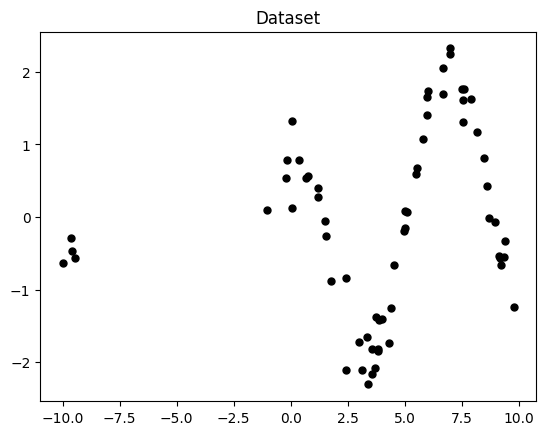

In [14]:
fig = plt.figure()
plt.plot(X, y, "ko", ms=5)
plt.title("Dataset")
plt.show()

In [15]:
Xtest_tensor = torch.from_numpy(Xtest_).to(device)

## Pretrain a Deterministic Neural Network

In [16]:
# deterministic network setup
util.set_seed(1)
width = 50              # Number of units in each hidden layer
depth = 2               # Number of hidden layers
transfer_fn = "tanh"    # Activation function

Epochs: 100%|██████████████████████████████| 4000/4000 [00:04<00:00, 951.38it/s]


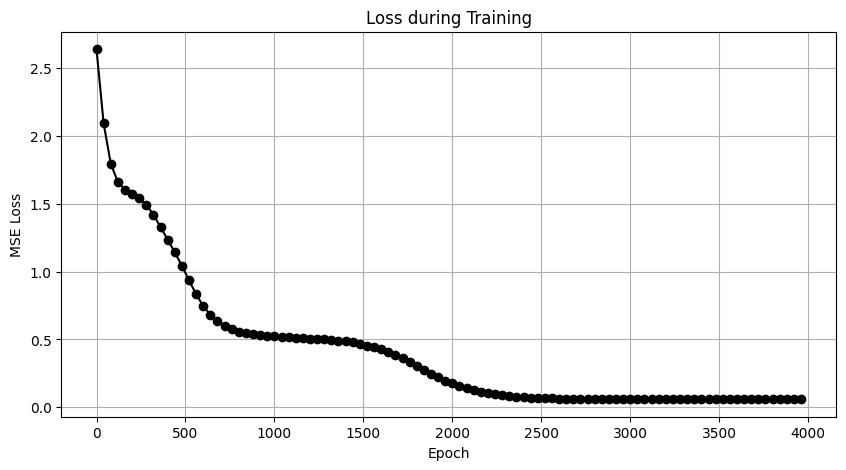

In [17]:
# Initialize Parameters
T = 4000
det_mlp_std = DetMLPNP(input_dim=1, output_dim=1, activation_fn=transfer_fn, hidden_dims=[width]*depth)
det_mlp_std = det_mlp_std.to(device)
loss_history = np.array([])
loss_fn = nn.MSELoss()
optimizer = optim.Adam(det_mlp_std.parameters(), lr=0.001)
X_tensor = torch.from_numpy(X).float().to(device)
y_tensor = torch.from_numpy(y).float().to(device)
for _ in tqdm(range(T), desc="Epochs"):
    optimizer.zero_grad()
    output = det_mlp_std(X_tensor)
    loss = loss_fn(output, y_tensor)
    loss.backward()
    optimizer.step()
    loss_history = np.append(loss_history, loss.item())

indices = np.arange(T)[::40]
plt.figure(figsize=(10, 5))
plt.plot(indices, loss_history[indices], "-ko")
plt.title("Loss during Training")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.show()

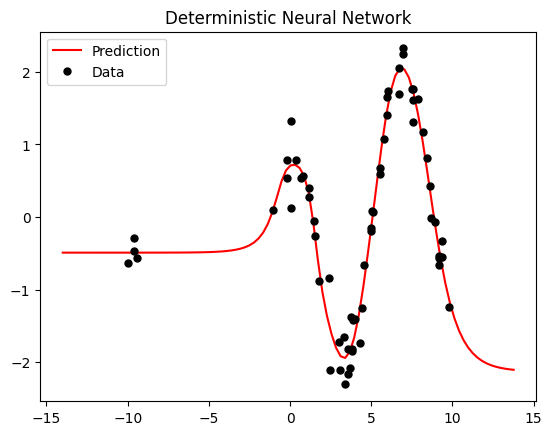

In [18]:
# show fit
X_plot = torch.tensor(np.linspace(min(X)-4, max(X)+4, 100)).float().to(device)

y_plot = det_mlp_std.forward(X_plot) 
X_plot = X_plot.detach().cpu().numpy()
y_plot = y_plot.detach().cpu().numpy()
plt.plot(X_plot, y_plot, 'r-', label='Prediction') 

plt.plot(X, y, "ko", ms=5, label='Data')

plt.title(f"Deterministic Neural Network")
plt.legend()

plt.show()

In [19]:
# Transform the pretrained network into a partially stochastic network
ps_mlp_std = det_mlp_std.convert_to_partially_stochastic_mlp(pruned = False, pos_stochasticity="highest",
                                                                       num_stochastic=1, stoch_layer_inds=[0])

ps_mlp_std = ps_mlp_std.to(device)

## Optimize the Prior with sparsity

In [26]:
# Initialize BNN Priors
D = 3                   # Factorization depth for stochasticity
opt_bnn_sparse = FactorizedGaussianMLPReparameterization(input_dim=1, output_dim=1, D = D, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth, device = device)
opt_bnn_wasserstein = GaussianMLPReparameterization(input_dim=1, output_dim=1, activation_fn=transfer_fn, 
    hidden_dims=[width]*depth)

opt_bnn_wasserstein = opt_bnn_wasserstein.to(device)
opt_bnn_sparse = opt_bnn_sparse.to(device)

In [21]:
# GP hyper-parameters
sn2 = 0.1   # noise variance
leng = 0.6  # lengthscale
ampl = 1.0  # amplitude

# We use a grid of 200 data points in [-6, 6] for the measurement set
util.set_seed(1)
likelihood = LikGaussian(sn2)
data_generator = GridGenerator(-6, 6)

kernel = RBF(
        input_dim=1, ARD=True,
        lengthscales=torch.tensor([leng], dtype=torch.double),
        variance=torch.tensor([ampl], dtype=torch.double))
gpmodel = GPR(X=torch.from_numpy(X_).to(device),
              Y=torch.from_numpy(y_).reshape([-1, 1]).to(device),
              kern=kernel, mean_function=Zero())
gpmodel.likelihood.variance.set(sn2)
gpmodel = gpmodel.to(device)

In [22]:
# Hyperparameters for prior optimization
num_iters_sd = 10000
n_data = 13
n_samples = 128
print_every = 50
lambd_sd = torch.tensor([5e-1, 1.])

In [23]:
util.set_seed(1)
sinkhorn_mapper = SinkhornMapper(out_dir=OUT_DIR).to(device)
y_train_shape = y_tensor.shape
y_train = y_tensor.unsqueeze(2).expand(y_train_shape[0], n_samples, y_train_shape[1]) 
p_hist, loss_hist_sp = sinkhorn_mapper.optimize_sparse(net = opt_bnn_sparse, gp = gpmodel, data_generator = data_generator, 
            lambd= lambd_sd, n_data = n_data, num_iters = num_iters_sd, print_every=print_every, output_dim = 1, 
            D= D, X_train = X_tensor, y_train = y_train, n_samples= n_samples)

>>> Iteration #   1: Sinkhorn Dist 94.5582 Number of pruned stochastic weights: 0
>>> Iteration #  50: Sinkhorn Dist 65.5273 Number of pruned stochastic weights: 0
>>> Iteration # 100: Sinkhorn Dist 70.8652 Number of pruned stochastic weights: 1
>>> Iteration # 150: Sinkhorn Dist 68.6726 Number of pruned stochastic weights: 2
>>> Iteration # 200: Sinkhorn Dist 85.5726 Number of pruned stochastic weights: 2
>>> Iteration # 250: Sinkhorn Dist 75.2068 Number of pruned stochastic weights: 2
>>> Iteration # 300: Sinkhorn Dist 73.2676 Number of pruned stochastic weights: 2
>>> Iteration # 350: Sinkhorn Dist 78.0035 Number of pruned stochastic weights: 3
>>> Iteration # 400: Sinkhorn Dist 73.5919 Number of pruned stochastic weights: 3
>>> Iteration # 450: Sinkhorn Dist 76.5085 Number of pruned stochastic weights: 3
>>> Iteration # 500: Sinkhorn Dist 65.6024 Number of pruned stochastic weights: 5
>>> Iteration # 550: Sinkhorn Dist 73.6086 Number of pruned stochastic weights: 7
>>> Iteration # 

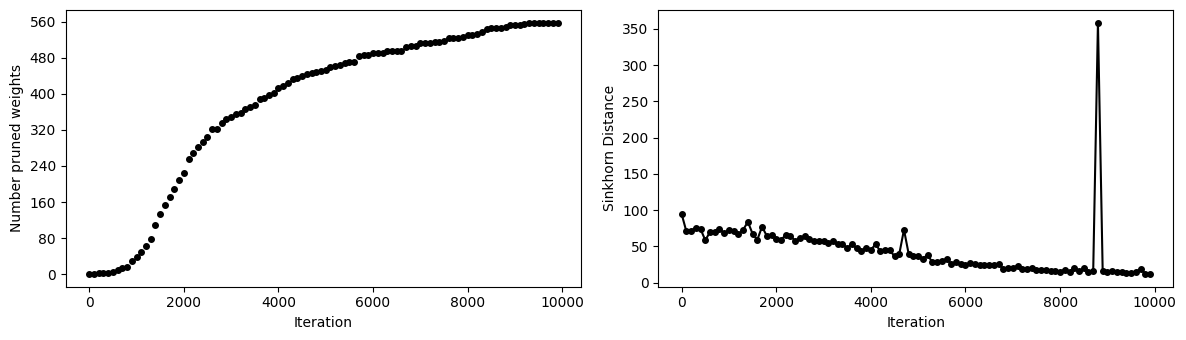

In [27]:
# Visualize progression of the prior optimization
indices = np.arange(num_iters_sd)[::100]

fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))  
axes[0].plot(indices, p_hist[indices], "ko", ms=4)
axes[0].set_ylabel("Number pruned weights")
axes[0].set_xlabel("Iteration")
axes[0].yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

axes[1].plot(indices, loss_hist_sp[indices], "-ko", ms=4)
axes[1].set_ylabel("Sinkhorn Distance")
axes[1].set_xlabel("Iteration")

plt.tight_layout()
plt.show()

## Optimize the Prior with Wasserstein

In [28]:
mapper_num_iters = 800 # Define the number of iterations of Wasserstein optimization
# Initiialize the Wasserstein optimizer
util.set_seed(1)
mapper = MapperWasserstein(gpmodel, opt_bnn_wasserstein, data_generator,
                           out_dir=OUT_DIR, 
                           wasserstein_steps=(0, 1000),
                           wasserstein_lr=0.08,
                           n_data=200, n_gpu=1, gpu_gp=True)

# Start optimizing the prior
w_hist = mapper.optimize(num_iters=mapper_num_iters, n_samples=512, lr=0.01, 
                         save_ckpt_every=50, print_every=20, debug=True)
path = os.path.join(OUT_DIR, "wsr_values.log")
np.savetxt(path, w_hist, fmt='%.6e')        

>>> Iteration #   1: Wasserstein Dist 34.5429
>>> Iteration #  20: Wasserstein Dist 22.6244
>>> Iteration #  40: Wasserstein Dist 19.3580
>>> Iteration #  60: Wasserstein Dist 17.3391
>>> Iteration #  80: Wasserstein Dist 15.7443
>>> Iteration # 100: Wasserstein Dist 14.7961
>>> Iteration # 120: Wasserstein Dist 14.6553
>>> Iteration # 140: Wasserstein Dist 13.8471
>>> Iteration # 160: Wasserstein Dist 14.1635
>>> Iteration # 180: Wasserstein Dist 13.1852
>>> Iteration # 200: Wasserstein Dist 12.3456
>>> Iteration # 220: Wasserstein Dist 12.9731
>>> Iteration # 240: Wasserstein Dist 12.3652
>>> Iteration # 260: Wasserstein Dist 12.6947
>>> Iteration # 280: Wasserstein Dist 12.7227
>>> Iteration # 300: Wasserstein Dist 11.5976
>>> Iteration # 320: Wasserstein Dist 11.4311
>>> Iteration # 340: Wasserstein Dist 11.5322
>>> Iteration # 360: Wasserstein Dist 11.2610
>>> Iteration # 380: Wasserstein Dist 11.3195
>>> Iteration # 400: Wasserstein Dist 11.6254
>>> Iteration # 420: Wasserstein D

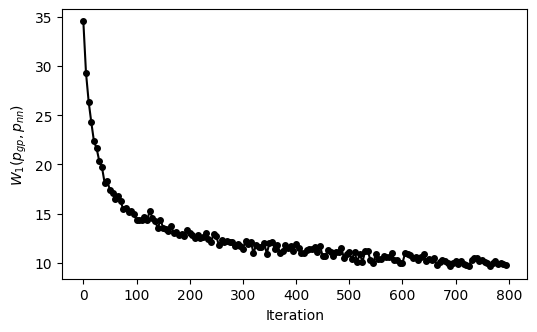

In [29]:

# Visualize progression of the prior optimization
wdist_file = os.path.join(OUT_DIR, "wsr_values.log")
wdist_vals = np.loadtxt(wdist_file)

fig = plt.figure(figsize=(6, 3.5))
indices = np.arange(mapper_num_iters)[::5]
plt.plot(indices, wdist_vals[indices], "-ko", ms=4)
plt.ylabel(r"$W_1(p_{gp}, p_{nn})$")
plt.xlabel("Iteration")
plt.show()

## Compare Functional Prior

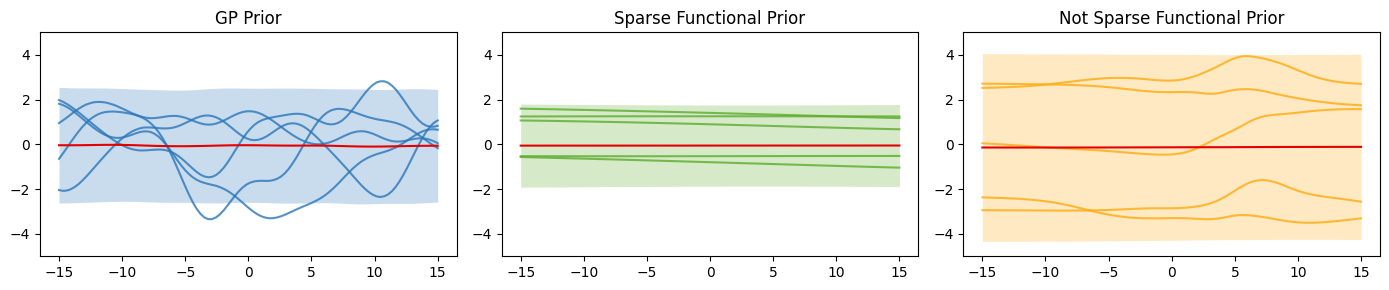

In [30]:
# Load the optimize prior
util.set_seed(1)
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
opt_bnn.load_state_dict(torch.load(ckpt_path))

# Draw functions from the priors
n_plot = 4000
util.set_seed(8)

gp_samples = gpmodel.sample_functions(
   Xtest_tensor, n_plot).detach().cpu().numpy().squeeze()
gp_samples = zscore_unnormalization(gp_samples, y_mean, y_std)

sparse_opt_samples = opt_bnn_sparse.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
sparse_opt_samples = zscore_unnormalization(sparse_opt_samples, y_mean, y_std)

wasserstein_opt_samples = opt_bnn_wasserstein.sample_functions(
    Xtest_tensor.float(), n_plot).detach().cpu().numpy().squeeze()
wasserstein_opt_samples = zscore_unnormalization(wasserstein_opt_samples, y_mean, y_std)


fig, axs = plt.subplots(1, 3, figsize=(14, 3))
plot_samples(Xtest, gp_samples, ax=axs[0], n_keep=5)
axs[0].set_title('GP Prior')
axs[0].set_ylim([-5, 5])

plot_samples(Xtest, sparse_opt_samples, ax=axs[1], color='xkcd:grass', n_keep=5)
axs[1].set_title('Sparse Functional Prior')
axs[1].set_ylim([-5, 5])

plot_samples(Xtest, wasserstein_opt_samples, ax=axs[2], color='xkcd:yellowish orange', n_keep=5)
axs[2].set_title('Wasserstein Functional Prior')
axs[2].set_ylim([-5, 5])

plt.tight_layout()
plt.show()

# Posterior Inference

In [31]:
# SGHMC Hyper-parameters
sampling_configs = {
    "batch_size": 16,           # Mini-batch size
    "num_samples": 30,          # Total number of samples for each chain
    "n_discarded": 10,          # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 1500,  # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,          # Thinning interval
    "lr": 0.01,                 # Step size
    "num_chains": 4,            # Number of chains
    "mdecay": 0.01,             # Momentum coefficient
    "print_every_n_samples": 5,
    "prevent_overfitting" : "WCP"
}

# Get the masks for determinstic weights
weights_mask_sd, bias_mask_sd = opt_bnn_sparse.get_det_masks()

## Pretrained Neural Network

In [32]:
# Configurations of Posterior Sampler
util.set_seed(8)
num_burn_in_steps = 2000
adapted = True
batch_size =  32
num_samples = 30 
num_chains = 4
num_datapoints = X.shape[0]
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [33]:
mapper_sampler = Mapper_Sampler(likelihood, adapted = adapted).to(device)
mapper_sampler.sample_multi_chains(net = ps_mlp_std, data_loader=dataloader, X= X_tensor, y= y_tensor, 
                                       num_burn_in_steps=num_burn_in_steps, num_samples= num_samples, 
                                       num_datapoints=num_datapoints, num_chains= 4)

Chain: 1


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [ ]:
# Make predictions
util.set_seed(1)
_, _, y_preds_pretrained = ps_mlp_std.predict(Xtest, mapper_sampler.sampled_weights, True)
# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(y_preds_pretrained, num_chains)

print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
y_preds_pretrained = y_preds_pretrained.squeeze().T


## Optimized Prior Sparse

In [ ]:
# Load the optimized prior
util.set_seed(1)
ckpt_path_sparse = os.path.join(OUT_DIR, "ckpts", "sparse-it-{}.ckpt".format(num_iters_sd))
prior_optim_sparse = OptimGaussianPrior(ckpt_path_sparse)

# Setup likelihood
likelihood = LikGaussian(sn2)
net_optim_sparse = MLPMasked(1, 1, [width]*depth, transfer_fn, weights_mask_sd, bias_mask_sd, device=device)
# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_optim_sparse")
util.ensure_dir(saved_dir)
net_optim_sparse.change_hook(False)
ps_net_optim_sparse = RegressionNetMasked(net_optim_sparse, likelihood, prior_optim_sparse, saved_dir, n_gpu=n_gpu)

# Start sampling
ps_net_optim_sparse.sample_multi_chains(X, y, **sampling_configs)

In [ ]:
# Make predictions
_, _, ps_optim_sparse_preds = ps_net_optim_sparse.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(ps_optim_sparse_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
ps_optim_sparse_preds = ps_optim_sparse_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR, "posterior_optim_sparse.npz")
np.savez(posterior_optim_path, bnn_samples=ps_optim_sparse_preds)

## Optimized Prior Wasserstein

In [ ]:
# SGHMC Hyper-parameters
sampling_configs = {
    "batch_size": 16,           # Mini-batch size
    "num_samples": 30,          # Total number of samples for each chain
    "n_discarded": 10,          # Number of the first samples to be discared for each chain
    "num_burn_in_steps": 1500,  # Number of burn-in steps, 2000 yields better MSE
    "keep_every": 200,          # Thinning interval
    "lr": 0.01,                 # Step size
    "num_chains": 4,            # Number of chains
    "mdecay": 0.01,             # Momentum coefficient
    "print_every_n_samples": 5
}

In [ ]:
# Load the optimized prior
ckpt_path = os.path.join(OUT_DIR, "ckpts", "it-{}.ckpt".format(mapper_num_iters))
prior = OptimGaussianPrior(ckpt_path)

# Setup likelihood
net = MLP(1, 1, [width]*depth, transfer_fn, device = device)
likelihood = LikGaussian(sn2)

# Initialize the sampler
saved_dir = os.path.join(OUT_DIR, "sampling_optim_wasserstein")
util.ensure_dir(saved_dir)
wasserstein_net_optim = RegressionNet(net, likelihood, prior, saved_dir, n_gpu=0)

# Start sampling
wasserstein_net_optim.sample_multi_chains(X, y, **sampling_configs)

In [ ]:
# Make predictions
util.set_seed(1)
_, _, wasserstein_net_optim_preds = wasserstein_net_optim.predict(Xtest, True)

# Convergence diagnostics using the R-hat statistic
r_hat = compute_rhat_regression(wasserstein_net_optim_preds, sampling_configs["num_chains"])
print(r"R-hat: mean {:.4f} std {:.4f}".format(float(r_hat.mean()), float(r_hat.std())))
wasserstein_net_optim_preds = wasserstein_net_optim_preds.squeeze().T

# Save the predictions
posterior_optim_path = os.path.join(OUT_DIR, "posterior_optim_wasserstein.npz")
np.savez(posterior_optim_path, bnn_samples=wasserstein_net_optim_preds)

# Visualize Predictive Posterior

In [ ]:
util.set_seed(9)
fig, axs = plt.subplots(1, 3, figsize=(14, 3))

plot_samples(Xtest, y_preds_pretrained, ax=axs[0], color='xkcd:grass', n_keep=16)
axs[0].plot(X, y, 'ok', zorder=10, ms=5)
axs[0].set_title('Pretrained Neural Network')
axs[0].set_ylim([-4, 4])

plot_samples(Xtest, ps_optim_sparse_preds, ax=axs[1], color='xkcd:grass', n_keep=16)
axs[1].plot(X, y, 'ok', zorder=10, ms=5)
axs[1].set_title('Optimized Prior Sparse')
axs[1].set_ylim([-4, 4])

plot_samples(Xtest, ps_optim_not_sparse_preds, ax=axs[2], color='xkcd:yellowish orange', n_keep=16)
axs[2].plot(X, y, 'ok', zorder=10, ms=5)
axs[2].set_title('Optimized Prior not Sparse')
axs[2].set_ylim([-4, 4])

plt.tight_layout()
plt.show()